### Imports

In [79]:
import pandas as pd
import numpy as np

from pandas_datareader.data import DataReader
from pandas_datareader.nasdaq_trader import get_nasdaq_symbols

import yfinance as yf
yf.pdr_override()

# Feature Engineering
from sklearn.preprocessing import StandardScaler

# Machine Learning
from sklearn.cluster import KMeans
from sklearn import metrics
from kneed import KneeLocator

# Cointegration
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint

# Plotting - Visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.manifold import TSNE

### Get Data

In [94]:
# Parameters
start_date = '2017-01-01'
end_date = '2024-01-01'

etf_data_filename = 'data/raw_etf_data.csv'
coint_data_filename = 'data/raw_coint_pairs_data.csv'

is_loaded_etf_data = True
is_loaded_coint_pairs_data = True


In [81]:
# Get Data

if not is_loaded_etf_data:
    symbols = get_nasdaq_symbols()
    symbols = symbols[(symbols['ETF']==True) &(symbols['Market Category']== "G")]
    symbols = symbols.index.tolist()    
    data = DataReader(symbols, start_date, end_date)['Adj Close']
    data.to_csv(etf_data_filename)

[*********************100%%**********************]  594 of 594 completed


5 Failed downloads:
['MCHS', 'BRRR', 'SKRE', 'MEMS', 'DYFI']: Exception("%ticker%: Data doesn't exist for startDate = 1483246800, endDate = 1704085200")


In [82]:
# Load Data and Refactor

loaded_etf_data = pd.read_csv(etf_data_filename)
loaded_etf_data.dropna(inplace=True,axis=1)
loaded_etf_data = loaded_etf_data.set_index('Date')

print(f"null values {loaded_etf_data.isnull().values.any()}")
print(f"shape {loaded_etf_data.shape}")
loaded_etf_data.head()


null values False
shape (1760, 259)


,AADR,AAXJ,ACWI,ACWX,AGNG,AGZD,AIA,AIRR,ALTY,ANGL,...,VTHR,VTIP,VTWG,VTWO,VTWV,VWOB,VXUS,VYMI,WOOD,XT
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03 00:00:00,38.266666,48.610233,52.050152,33.607410,14.513459,14.884954,40.685699,23.451797,8.660429,20.295166,...,92.506104,39.782997,106.655472,49.565151,91.095413,55.973507,37.490688,42.702919,47.666119,25.109819
2017-01-04 00:00:00,38.925316,49.092216,52.495319,33.980911,14.513459,14.918933,40.903084,23.797682,8.782164,20.358395,...,93.569313,39.799187,108.894699,50.308537,92.473640,56.196552,37.904469,43.135925,48.091225,25.436159
2017-01-05 00:00:00,39.342773,49.784515,52.696091,34.271427,14.513459,14.915841,41.407413,23.393661,8.847667,20.407562,...,93.399536,39.847748,108.056190,49.806854,91.227081,56.556274,38.188427,43.553993,48.055805,25.520075
2017-01-06 00:00:00,39.212898,49.539150,52.704803,34.130318,14.513459,14.903489,41.233505,23.393661,8.932878,20.428642,...,93.640778,39.782997,107.503517,49.597076,90.735466,56.397991,38.107296,43.322559,48.055805,25.566696
2017-01-09 00:00:00,39.352047,49.582962,52.582607,34.080517,14.513459,14.866423,41.346550,22.900957,8.875490,20.442692,...,93.319130,39.807278,107.436821,49.264141,89.638153,56.541878,38.034283,43.203114,47.745827,25.629166


### Feature Engineering

In [83]:
# We will be working with Returns and Volatility

df_featured = pd.DataFrame(loaded_etf_data.pct_change().mean()*252,columns=['Returns'])
df_featured['Volatility'] =loaded_etf_data.pct_change().std()*np.sqrt(252)
df_featured.head()

,Returns,Volatility
AADR,0.080586,0.224497
AAXJ,0.066470,0.206656
ACWI,0.112538,0.180856
ACWX,0.076196,0.179948
AGNG,0.112798,0.180827


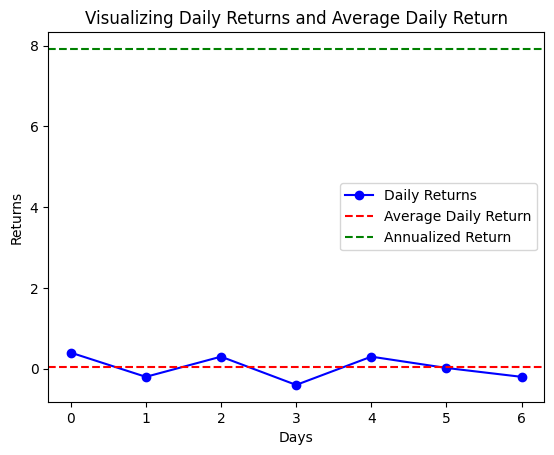

In [84]:
### To help understand the logic above...
returns_data = pd.Series([0.4, -0.2, 0.3, -0.4,0.3,0.02,-0.2])
average_daily_return = returns_data.mean()
annualized_return = average_daily_return * 252

# Plot daily returns
plt.plot(returns_data, marker='o', linestyle='-', color='b', label='Daily Returns')

# Plot average daily return as a horizontal line
plt.axhline(y=average_daily_return, linestyle='--', color='r', label='Average Daily Return')

# Plot annualized return as a horizontal line
plt.axhline(y=annualized_return, linestyle='--', color='g', label='Annualized Return')

# Labeling
plt.xlabel('Days')
plt.ylabel('Returns')
plt.legend()
plt.title('Visualizing Daily Returns and Average Daily Return')
plt.show()

In [85]:
# Scale Features

scaler = StandardScaler()
scaler = scaler.fit_transform(df_featured)

df_scaled = pd.DataFrame(scaler,columns=df_featured.columns,index=df_featured.index)
df_scaled.head()

,Returns,Volatility
AADR,-0.100598,0.223925
AAXJ,-0.288638,0.035571
ACWI,0.325056,-0.236819
ACWX,-0.159077,-0.246399
AGNG,0.328517,-0.237122


### K-Means Clustering

In [86]:
# Optimum number of clusters ?

X = df_scaled.copy()

distortions = []

for k in range(1,15):
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)

kl=KneeLocator(K, distortions, curve='convex', direction='decreasing')
c = kl.elbow

print(f"Optimum number of clusters {c}")

c:\Users\Kreator\anaconda3\envs\MLTRADE\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Optimum number of clusters 5


In [87]:
# Fit The Model

k_means = KMeans(n_clusters=c)
k_means.fit(X)
prediction = k_means.predict(df_scaled)


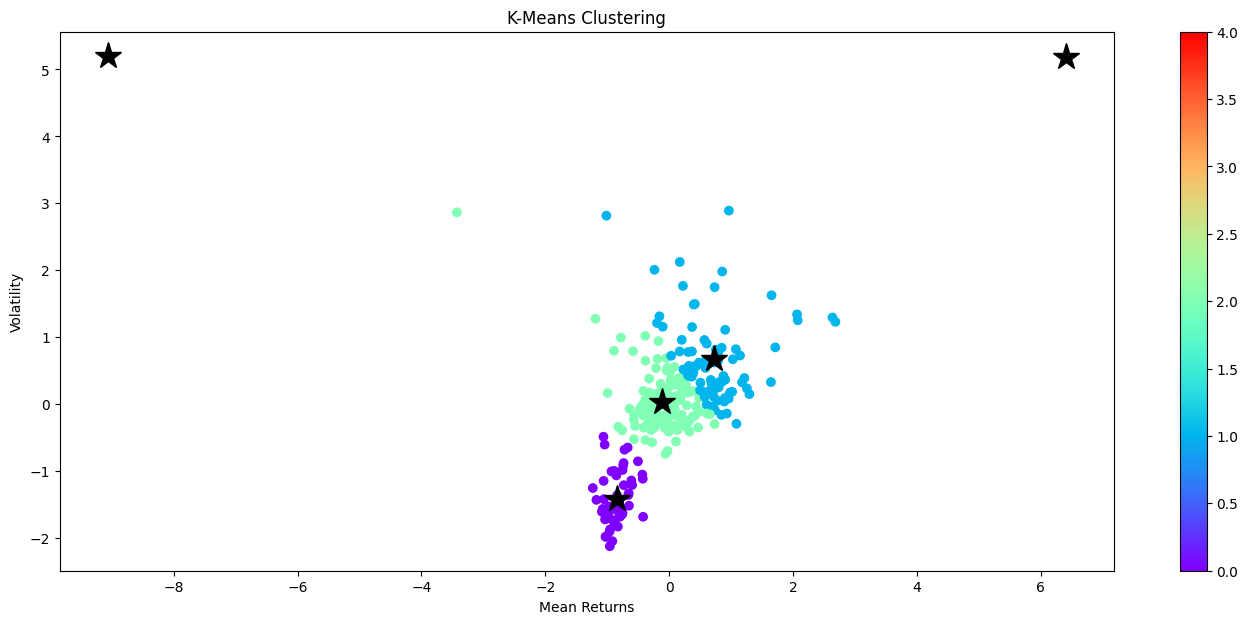

In [88]:
# Plotting

centroids = k_means.cluster_centers_
fig = plt.figure(figsize=(17, 7))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0],X.iloc[:,1],c=k_means.labels_,cmap="rainbow",label=X.index)
ax.set_title('K-Means Clustering')
ax.set_xlabel('Mean Returns')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)
plt.plot(centroids[:,0],centroids[:,1],'k*',markersize=20)
plt.show()


In [89]:
# Return Series

clustered_series = pd.Series(index=X.index,data=k_means.labels_.flatten())
clustered_series_all = pd.Series(index=X.index,data=k_means.labels_.flatten())
clustered_series = clustered_series[clustered_series != -1]
clustered_series

AADR    2
AAXJ    2
ACWI    2
ACWX    2
AGNG    2
       ..
VWOB    0
VXUS    2
VYMI    2
WOOD    2
XT      1
Length: 259, dtype: int32

2    123
1     83
0     51
3      1
4      1
dtype: int64


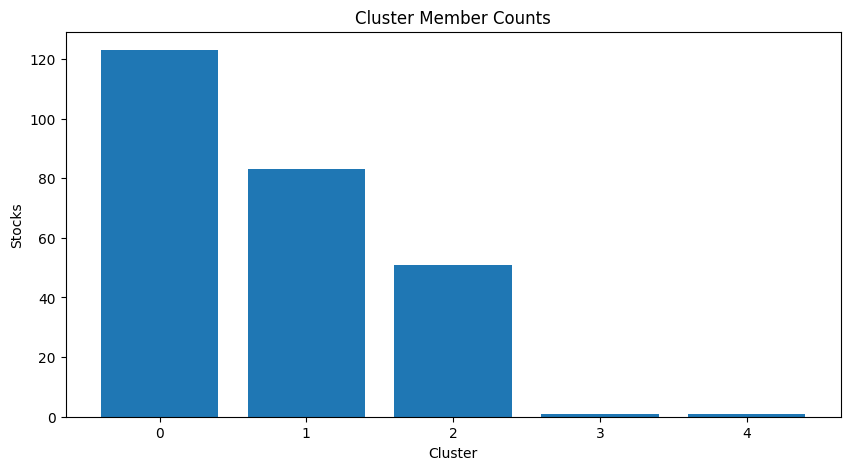

In [90]:
# Plotting
print(clustered_series.value_counts())
plt.figure(figsize=(10,5))
plt.bar(range(len(clustered_series.value_counts())),clustered_series.value_counts())
plt.xlabel('Cluster')
plt.ylabel('Stocks')
plt.title('Cluster Member Counts')
plt.show()

clean cluster  AADR    2
AAXJ    2
ACWI    2
ACWX    2
AGNG    2
AGZD    0
AIA     2
AIRR    1
ALTY    2
ANGL    0
dtype: int32
Clean stocks number 257
Original stocks number 259


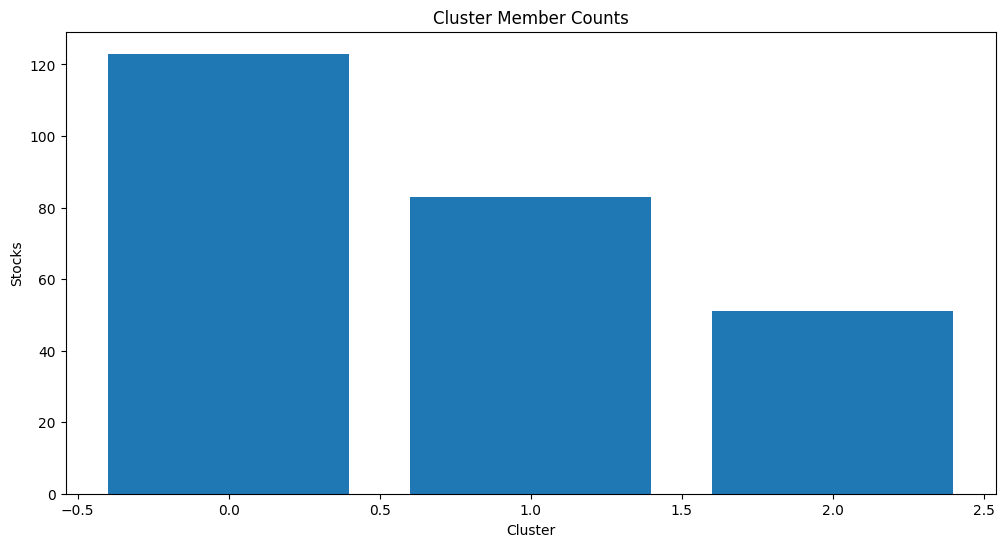

In [97]:
# Remove Outliers

clusters_clean = clustered_series[clustered_series < 3]

print(f"clean cluster  {clusters_clean.head(10)}")
print(f"Clean stocks number {len(clusters_clean)}")
print(f"Original stocks number {len(clustered_series)}")

plt.figure(figsize=(12,6))
plt.bar(range(len(clusters_clean.value_counts())),clusters_clean.value_counts())
plt.xlabel('Cluster')
plt.ylabel('Stocks')
plt.title('Cluster Member Counts')
plt.show()


### Cointegration to find which pairs belong to the same cluster

In [92]:
# Calculate Cointegration

def calculate_cointegration(series_1, series_2):
    # series_1 and series_2 are series containing prices of two stocks
    coint_flag = 0
    coint_res = coint(series_1, series_2)

    coint_t = coint_res[0] # strength of cointegration
    p_value = coint_res[1]
    critical_value = coint_res[2][1]

    # get hedge ratio
    model = sm.OLS(series_1, series_2).fit()
    hedge_ratio = model.params[0]

    # check for cointegration
    # 0.1, 0.05, 0.01 are the confidence levels for rejecting the null hypothesis
    # if p-value is less than this, we have evidence for cointegration
    coint_flag = 1 if p_value < 0.05 and coint_t < critical_value else 0
    return coint_flag, hedge_ratio

In [98]:
# Loop and calculate cointegrated pairs

tested_pairs=[]
cointegrated_pairs=[]

if not is_loaded_coint_pairs_data:
    # we use the cluster from above thats is cleaned from outliners
    for base_asset in clusters_clean.index:
        # cluster_clean.index is the ticker of the stocks

        base_label = clusters_clean[base_asset] # cluster label of the base asset

        for quote_asset in clusters_clean.index:
            compare_label = clusters_clean[quote_asset] # cluster label of the compared asset

            if base_asset != quote_asset and base_label == compare_label and (quote_asset,base_asset) not in tested_pairs:
                tested_pairs.append((base_asset,quote_asset))
                coint_flag, hedge_ratio = calculate_cointegration(loaded_etf_data[base_asset], loaded_etf_data[quote_asset])
                if coint_flag == 1:
                    cointegrated_pairs.append({"base_asset":base_asset,"compared_asset":quote_asset,"label":compare_label,"hedge_ratio":hedge_ratio})


    cointegrated_pairs_df = pd.DataFrame(cointegrated_pairs).sort_values(by=['label'])
    cointegrated_pairs_df.to_csv(coint_data_filename)

In [99]:
# Load Data

df_coint_pairs = pd.read_csv(coint_data_filename).iloc[:,1:]
df_coint_pairs.head()



,base_asset,compared_asset,label,hedge_ratio
0,MFLX,PFF,0,0.545369
1,GOVI,MBB,0,0.327130
2,HISF,VTIP,0,0.960913
3,LMBS,VGSH,0,0.814744
4,IUSB,VGIT,0,0.765087
